In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D ,Dense ,Dropout ,Flatten 
from keras.optimizers import Adam ,SGD

from sklearn.utils import shuffle  
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

import cv2
import pandas as pd
import random 
import ntpath
import os
import glob


from collections import Counter

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
data_path = "training_data/*.npz"

 # load training data
X = np.empty((0, 100 * 320))
y = np.empty((0, 1))
training_data = glob.glob(data_path)
    
if not training_data:
        print("Data not found, exit")
        sys.exit()

for single_npz in training_data:
    with np.load(single_npz) as data:
        train = data['train']
        train_labels = data['train_labels']
    X = np.vstack((X, train))
    y = np.vstack((y, train_labels))
    
print(X.shape)
print(y.shape)


(1372, 32000)
(1372, 1)


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2 ,random_state = 6) #

(1097, 32000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


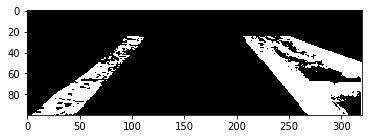

In [5]:
print(X_train.shape)
plt.imshow(X_train[10].reshape(100,320),cmap="gray")
print(X_train[10].reshape(100,320))

In [6]:
#draw blue line above the line which it is detected by canny
def region_of_interest(image):
    #detect the rigion of interest 
    
    #take the hight of the image which mean y coordinate
    hight = image.shape[0]
    
    #detect the parameters of polygon
    polys = np.array([[(0,hight),(320,hight),(320,10),(0,10)]])
    
    #make a black image and this size equal the oraginal image
    mask = np.zeros_like(image)
    
    #draw a polygon and fill inside it by a white color
    cv2.fillPoly(mask,polys,1)
    
    #do an AND operator between the mask and the orginal image
    #the output will be only the line in the street
    image_AND = cv2.bitwise_and(image,mask)

    return image_AND

def process_img(img):
    
    img = img.reshape(100,320,1)
    img = np.max(img)-img
    img = img/np.max(img)
    _,img = cv2.threshold(img,0.6,1,cv2.THRESH_BINARY)
    img = region_of_interest(img)

    return img



In [7]:
# img = process_img(X_train[50])
# print(img.shape)
# plt.imshow(img,cmap="gray")

(100, 320, 1)


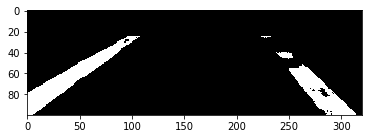

In [8]:
# X_train = np.array(list(map(process_img,X_train)))
X_train = X_train.reshape(len(X_train),100,320,1)


# X_valid = np.array(list(map(process_img,X_valid)))
X_valid = X_valid.reshape(len(X_valid),100,320,1)


print(X_train[1].shape)
plt.imshow(X_train[1].reshape(100,320),cmap="gray")

In [9]:
y_train = to_categorical(y_train,3)
y_valid = to_categorical(y_valid,3)


In [10]:
print(y_train[100])
print(X_train.shape)

[0. 0. 1.]
(1097, 100, 320, 1)


In [11]:
def leNet_model():
    
    model = Sequential()
    
    model.add(Conv2D(30,(5,5),input_shape=(100,320,1),padding="valid",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
 
    model.add(Conv2D(15,(3,3),padding="valid",activation="relu"))
    model.add(Conv2D(15,(3,3),padding="valid",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(3,activation="softmax"))
    
    model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
    
    return model

In [12]:
model = leNet_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 316, 30)       780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 158, 30)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 156, 15)       4065      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 154, 15)       2040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 77, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)  

In [13]:
# create augmented images
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    shear_range=0.1,
                                    rotation_range=10.)

data_generator.fit(X_train)

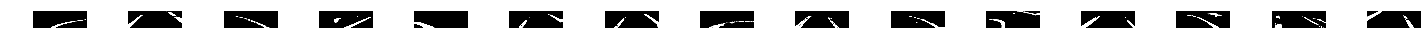

In [14]:
batches = data_generator.flow(X_train,y_train,batch_size=20)

X_batch ,y_batch = next(batches)

fig , axs = plt.subplots(1,15 ,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(100,320),cmap=plt.get_cmap("gray"))
  axs[i].axis("off")

In [15]:
history = model.fit(X_train, y_train, epochs=10,  validation_data=(X_valid,y_valid),batch_size = 50, verbose = 1, shuffle = 1)

# history = model.fit_generator(data_generator.flow(X_train,y_train,batch_size=50),
#                               steps_per_epoch=50,epochs=10,validation_data=(X_valid, y_valid), shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Train on 1097 samples, validate on 275 samples
Epoch 1/10
1097/1097 [==============================] - 71s 65ms/step - loss: 0.8163 - acc: 0.6281 - val_loss: 0.6737 - val_acc: 0.7055
Epoch 2/10
1097/1097 [==============================] - 61s 55ms/step - loss: 0.6220 - acc: 0.6974 - val_loss: 0.6624 - val_acc: 0.6545
Epoch 3/10
1097/1097 [==============================] - 52s 47ms/step - loss: 0.5160 - acc: 0.7457 - val_loss: 0.5760 - val_acc: 0.7127
Epoch 4/10
1097/1097 [==============================] - 52s 48ms/step - loss: 0.4487 - acc: 0.7730 - val_loss: 0.6123 - val_acc: 0.6727
Epoch 5/10
1097/1097 [==============================] - 52s 48ms/step - loss: 0.4048 - acc: 0.8104 - val_loss: 0.6078 - val_acc: 0.6873
Epoch 6/10
1097/1097 [==============================] - 52s 48ms/step - loss: 0.3546 - acc: 0.8478 - val_loss: 0.6316 - val_acc: 0.6945
Epoch 7/10
1097/1097 [==============================] - 58s 52ms/step - loss: 0.2884 - ac

Text(0.5, 0, 'epochs')

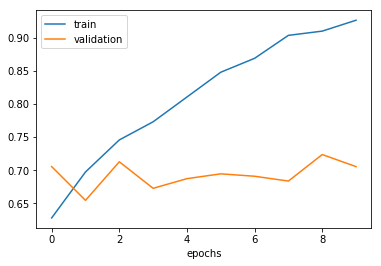

In [16]:
plt.plot(his.history["acc"])
plt.plot(his.history["val_acc"])
plt.legend(["train","validation"])
plt.xlabel("epochs")



Text(0.5, 0, 'epochs')

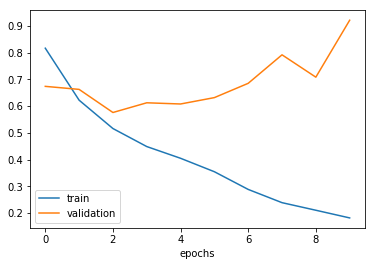

In [17]:
plt.plot(his.history["loss"])
plt.plot(his.history["val_loss"])
plt.legend(["train","validation"])
plt.xlabel("epochs")

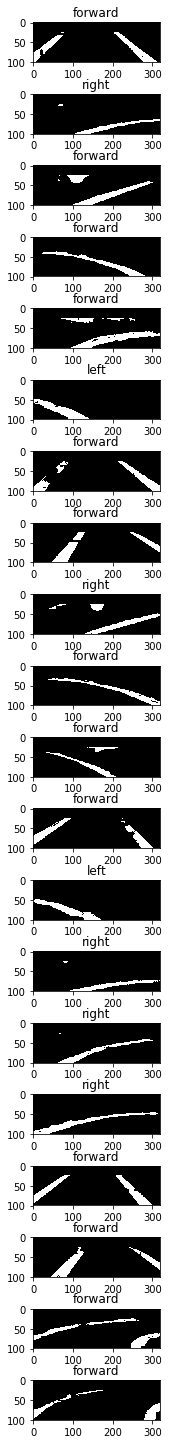

In [18]:
dirction = ["left","right","forward"]

i=100
j=120

fig, axs = plt.subplots(nrows=j-i, ncols=1, figsize=(5,j-i))
fig.tight_layout()


for k in range(i,j):
    img_preprocess = X_train[k].reshape(1,100,320,1)
    predict = model.predict_classes(img_preprocess)
    axs[k-i].imshow(img_preprocess.reshape(100,320),cmap=plt.get_cmap("gray"))
    axs[k-i].set_title(dirction[int(model.predict_classes(img_preprocess))])
    

#print("predicted : "+ str(model.predict_classes(img_preprocess)) + dirction[int(model.predict_classes(img_preprocess))])



In [19]:
model.save("model.xml")

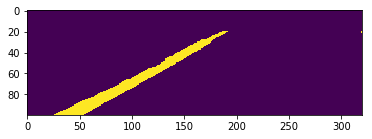

In [23]:
plt.imshow(X_train[300].reshape(100,320))

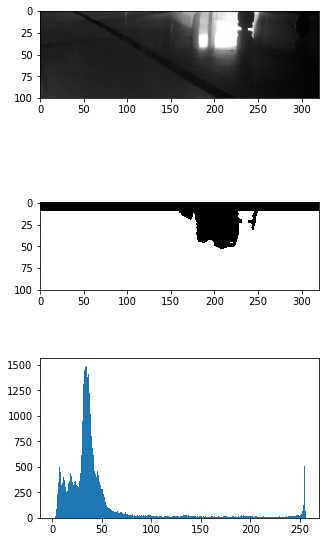

In [59]:
img_gray = cv2.imread("stop.jpg",0)
hight , width  = img_gray.shape

img_gray1 = img_gray[int(hight/2):hight-20 , :]
proc_img = process_img(img_gray1)


fig ,axs = plt.subplots(nrows=3,ncols=1,figsize=(5,10))

axs[0].imshow(img_gray1,cmap="gray")
axs[1].imshow(proc_img,cmap="gray")
axs[2].hist(img_gray1.ravel(),256,[0,256]);